# 🎮 Deep RL Final Project — MiniGrid Environments

## Overview
In this project, you will train deep RL agents on two MiniGrid environments. You must implement the core algorithms yourself using concepts from class.

**Read first:** Follow the instructions in the accompanying PDF. This notebook defines the environment APIs and where you may edit.

## Learning objectives
- Implement deep RL from scratch.
- Design observation preprocessing and reward shaping.
- Evaluate performance with clear metrics and plots.
- Communicate results in a concise report.

## 🌍 The Two Environments
| Environment | Description | Actions | Goal |
|-------------|-------------|---------|------|
| **`SimpleGridEnv`** | 8×8 empty room | 3 (Left, Right, Forward) | Navigate to the green goal square |
| **`KeyDoorBallEnv`** | Two rooms with locked door | 5 (Left, Right, Forward, Pickup, Toggle) | Get key → Open door → Pick up ball → Reach goal |

## ✅ What You CAN Modify
- **Preprocessing** — Implement your own observation preprocessing function.
- **Reward shaping** — Modify rewards in each `step()` method (see `# TODO`).
- **Observation space** — Update `self.observation_space` to match preprocessing output.

## ❌ What You CANNOT Modify
- Grid layout and generation logic.
- Action spaces or termination conditions.
- Environment mechanics (door/key/ball rules).
- **No external RL libraries** for the core algorithm (you may use PyTorch/TensorFlow).

## 📦 Deliverables & Submission
**Submit:** (1) this notebook with your full code and outputs, and (2) a report formatted **as specified in the instructions PDF**.

## 🧪 Reproducibility checklist
- Set random seeds for Python, NumPy, and your DL framework.
- Document hyperparameters.

## 🧾 Academic integrity
- You may discuss ideas, but code and write-up must be your own.
- Cite any external resources (blog posts, papers, code snippets).
---

# Setup

## Installs and Imports

### Installs (run once if needed)

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio
!pip install pyvirtualdisplay
!pip install gymnasium
!pip install minigrid
!pip install pygame

### Imports

In [ ]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Lava, Wall, Ball
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Environments

> ⚠️ **Important**
>
> The two environments below are **fixed**—do not modify grid layout, action spaces, or termination conditions.
>
> **You may modify only:**
> 1. **Observation space** — set `self.observation_space` to match your preprocessing output (see `# TODO`).
> 2. **Reward shaping** — edit reward logic inside `step()` (see `# TODO`).
>
> Look for the clearly marked sections in each environment class.

In [ ]:
# =============================================================================
# ENVIRONMENT 1: SIMPLE GRID (Empty Room)
# =============================================================================
class SimpleGridEnv(BaseMiniGridEnv):
    """
    A simple grid environment with no obstacles inside, just outer walls.
    The agent and goal positions are randomized at each reset.

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        preprocess=None,
        **kwargs,
    ):

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)


        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(320, 320, 1),
            dtype=np.uint8
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # Preprocessing function for observations
        self.preprocess = preprocess if preprocess is not None else lambda x: x
        self.walls_init = []
        # Default goal and agent starting position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0


    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])
        # 2. Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)
        # 3. Return the preprocessed observation
        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Procedurally generates the grid layout: walls, goal, and agent."""
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

        self.mission = "grand mission"

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Standard step function.

        Current reward scheme (sparse):
            - +1.0 when reaching the goal (terminated=True)
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        obs, reward, terminated, truncated, info = super().step(action)

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

In [ ]:
# =============================================================================
# ENVIRONMENT 2: KEY-DOOR WITH BALL PICKUP
# =============================================================================
class KeyDoorBallEnv(BaseMiniGridEnv):
    """
    Grid environment with two rooms separated by a locked door.

    Task sequence:
        1. Pick up key -> 2. Unlock door -> 3. Pick up ball -> 4. Reach goal

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
        3: Pick Up
        4: Toggle (open/close door)
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        partition_col=3,
        require_ball_pickup=True,
        preprocess=None,
        **kwargs,
    ):
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0
        self.partition_col = partition_col
        self.walls_init = []
        self.inventory = []
        self.require_ball_pickup = require_ball_pickup
        self.preprocess = preprocess if preprocess is not None else lambda x: x

        mission_space = MissionSpace(mission_func=self._gen_mission)
        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )

        # 5 actions: left, right, forward, pickup, toggle
        self.action_space = spaces.Discrete(5)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(320, 320, 1),
            dtype=np.uint8
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # State tracking for reward shaping (you can use these in your reward logic)
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "Pick up the key to open the door, pick up the ball, then reach the goal"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # Reset state tracking
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False
        self.inventory = []

        # Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)

        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Generate grid: walls, partition, door, key, ball, goal, agent."""
        # Grid with outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # Partition wall
        self.walls_init = [(self.partition_col, i) for i in range(height)]
        for col, row in self.walls_init:
            if 0 <= col < width and 0 <= row < height:
                self.grid.set(col, row, Wall())

        # Key in left room
        self.key_pos = (
            random.choice(range(1, self.partition_col)),
            random.choice(range(2, height - 1))
        )
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # Door in partition
        door_y = random.choice(range(1, height - 1))
        self.door_pos = (self.partition_col, door_y)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Goal
        self.goal_pos = (8, 8)
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Ball in right room (if required)
        if self.require_ball_pickup:
            right_x = range(self.partition_col + 2, width - 2)
            right_y = range(1, height - 1)
            while True:
                ball_x = random.choice(list(right_x))
                ball_y = random.choice(list(right_y))
                self.ball_pos = (ball_x, ball_y)
                if self.ball_pos != self.goal_pos:
                    break

            self.grid.set(ball_x, ball_y, Ball(COLOR_NAMES[1]))

        # Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

    def try_pickup_ball(self):
        """Pick up ball in front and add to inventory."""
        obj = self.grid.get(self.front_pos[0], self.front_pos[1])
        if isinstance(obj, Ball):
            self.grid.set(self.front_pos[0], self.front_pos[1], None)
            self.inventory.append(obj)

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Step function with sparse reward.

        Available helper methods for reward shaping:
            - self.is_carrying_key()  : Returns True if agent has the key
            - self.is_carrying_ball() : Returns True if agent has the ball
            - self.is_door_open()     : Returns True if door is open
            - self.prev_key           : Key status before this step
            - self.prev_door          : Door status before this step
            - self.prev_ball          : Ball status before this step

        Current reward scheme (sparse):
            - +1.0 for reaching goal with ball
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        # Map action 4 to toggle (internal MiniGrid uses 5 for toggle)
        if action == 4:
            action = 5

        # Track previous state for reward shaping
        self.prev_key = self.is_carrying_key()
        self.prev_door = self.is_door_open()
        self.prev_ball = self.is_carrying_ball()

        # Handle ball pickup
        if action == 3:
            self.try_pickup_ball()

        # Standard step
        obs, reward, terminated, truncated, info = super().step(action)

        # Goal only counts if ball is picked up (when required)
        terminated = terminated and (not self.require_ball_pickup or self.is_carrying_ball())

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: State getter methods (use these in reward shaping)   ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    def is_carrying_key(self):
        """Check if agent has key (in hand or inventory)."""
        key_in_hand = self.carrying and isinstance(self.carrying, Key)
        key_in_inventory = any(isinstance(item, Key) for item in self.inventory)
        return key_in_hand or key_in_inventory

    def is_carrying_ball(self):
        """Check if agent has ball (in hand or inventory)."""
        ball_in_hand = self.carrying and isinstance(self.carrying, Ball)
        ball_in_inventory = any(isinstance(item, Ball) for item in self.inventory)
        return ball_in_hand or ball_in_inventory

    def is_door_open(self):
        """Returns True if the door is open."""
        if hasattr(self, 'env_door'):
            return self.env_door.is_open
        return False

# Preprocessing Method

> 💡 **Student task:** Implement your own preprocessing function below.
>
> Your preprocessing function should:
> 1. Take a raw RGB image (320×320×3) as input.
> 2. Return a processed observation that **exactly matches** your `observation_space` (shape, dtype, value range).
>
> Common preprocessing techniques:
> - Crop edges to remove borders
> - Convert to grayscale
> - Resize to smaller dimensions
> - Normalize pixel values
>
> **Reminder:** Update `self.observation_space` in both environment classes to match your output.

In [ ]:
import cv2

# Example Preprocessing Function
def pre_process(img):
    """
    Preprocess raw RGB observation from the environment.

    Input:  RGB image (320, 320, 3)
    Output: Grayscale image (320, 320, 1)
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.expand_dims(gray, axis=-1)

# 🔍 Environment Examples & Exploration
Run the cells below to understand each environment before implementing your solution.
Use these quick tests to verify preprocessing output shape and rendering.

## Environment 1: SimpleGridEnv (Empty Room)

**Task**: Navigate to the green goal square in an empty 8×8 room.

| Property | Value |
|----------|-------|
| Grid Size | 8×8 |
| Agent Start | Random position (1-6, 1-6) |
| Agent Direction | Random (0-3) |
| Goal Position | Random: (8,1), (1,8), or (8,8) |
| Actions | 0: Turn Left, 1: Turn Right, 2: Move Forward |
| Sparse Reward | +1.0 on reaching goal, 0.0 otherwise |

### Quick Test

=== SimpleGridEnv ===
Action space:       Discrete(3)
Number of actions:  3
Observation space:  Box(0, 255, (320, 320, 1), uint8)  (ensure it matches preprocessing output)
Observation shape:  (320, 320, 1)
Agent direction:    1
Agent position:     (2, 4)
Goal position:      (1, 8)


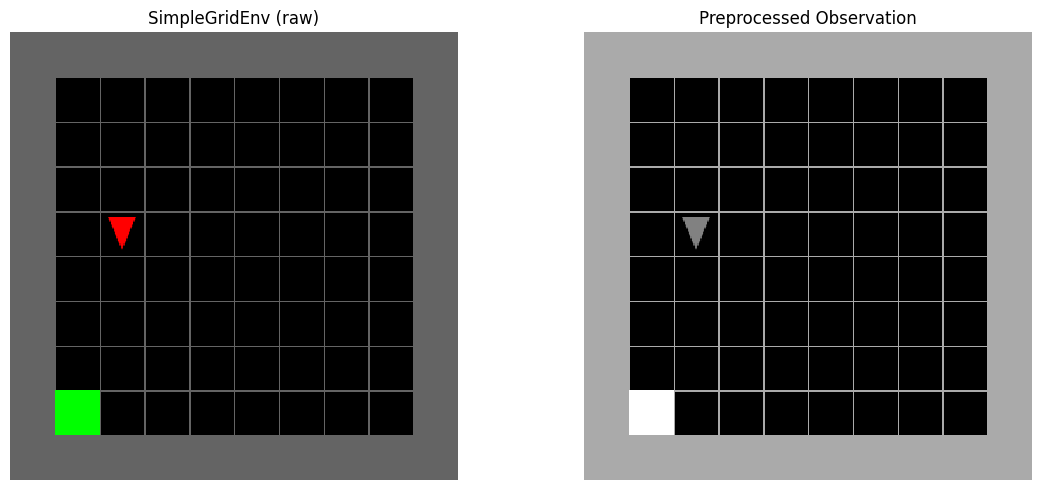

In [ ]:
# Initialize environment with preprocessing
env = SimpleGridEnv(max_steps=100, preprocess=pre_process)
obs = env.reset()[0]

print("=== SimpleGridEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("SimpleGridEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Environment 2: KeyDoorBallEnv (Key-Door-Ball Task)

**Task**: Complete a multi-step objective: Key → Door → Ball → Goal

| Property | Value |
|----------|-------|
| Grid Size | 8×8 (two rooms) |
| Partition Wall | Column 3 |
| Key Location | Left room (random) |
| Door Location | In partition wall (random row) |
| Ball Location | Right room (random) |
| Goal Position | Fixed at (8, 8) |
| Actions | 0: Left, 1: Right, 2: Forward, 3: Pickup, 4: Toggle |

**Sequence**: Pick up key → Open door → Enter right room → Pick up ball → Reach goal

**Helper Methods** (use in reward shaping):
- `is_carrying_key()` — True if agent has the key
- `is_carrying_ball()` — True if agent has the ball
- `is_door_open()` — True if door is open

### Quick Test

=== KeyDoorBallEnv ===
Action space:       Discrete(5)
Number of actions:  5
Observation space:  Box(0, 255, (320, 320, 1), uint8)  (ensure it matches preprocessing output)
Observation shape:  (320, 320, 1)
Agent direction:    0
Agent position:     (1, 1)
Goal position:      (8, 8)
Carrying key:       False
Door open:          False
Carrying ball:      False


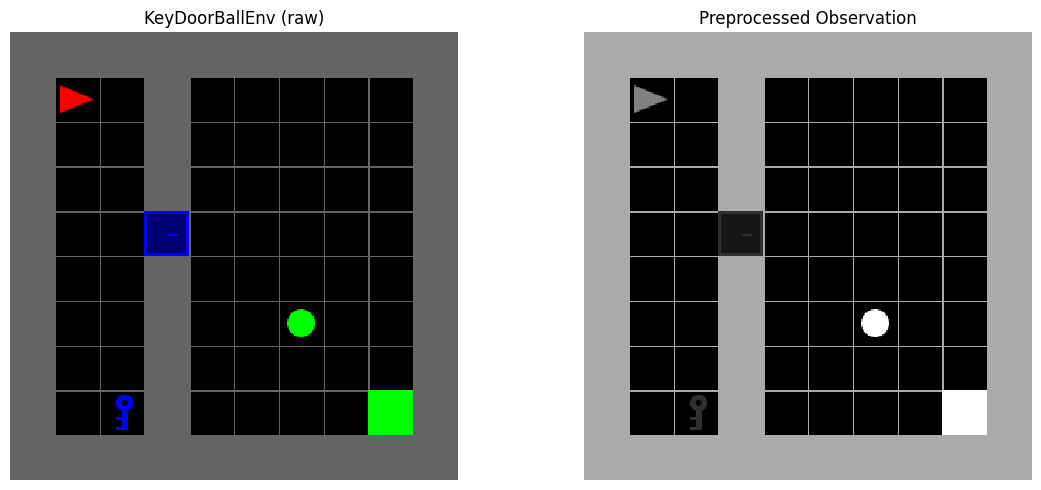

In [ ]:
# Initialize environment
env = KeyDoorBallEnv(max_steps=5000, preprocess=pre_process)
obs = env.reset()[0]

print("=== KeyDoorBallEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")
print(f"Carrying key:       {env.is_carrying_key()}")
print(f"Door open:          {env.is_door_open()}")
print(f"Carrying ball:      {env.is_carrying_ball()}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("KeyDoorBallEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Random action rollout + video
max_steps = 100
env = KeyDoorBallEnv(max_steps=max_steps, preprocess=pre_process)
num_actions = env.action_space.n
obs = env.reset()[0]
video_filename = "/content/KeyDoorBallEnv_random.mp4"

with imageio.get_writer(video_filename, fps=10) as video:
    obs, _ = env.reset()
    done = False
    total_reward = 0
    for step in range(max_steps):
        action = random.randint(0, num_actions - 1)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        video.append_data(env.render())
        if done:
            break

# Print episode summary
print("=== Episode Summary ===")
print(f"Steps:         {step + 1}")
print(f"Total reward:  {total_reward:.3f}")
print(f"Terminated:    {terminated}")
print(f"Truncated:     {truncated}")
print()
print("=== Environment Status (End of Episode) ===")
print(f"Agent position:  {env.agent_pos}")
print(f"Carrying key:    {env.is_carrying_key()}")
print(f"Door open:       {env.is_door_open()}")
print(f"Carrying ball:   {env.is_carrying_ball()}")

embed_mp4(video_filename)

=== Episode Summary ===
Steps:         100
Total reward:  0.000
Terminated:    False
Truncated:     True

=== Environment Status (End of Episode) ===
Agent position:  (np.int64(2), np.int64(8))
Carrying key:    True
Door open:       False
Carrying ball:   False


# Your Code Below